This notebook takes a few ideas from a package developed from Xi Chen to help evaluate the placement of vertical levels, and to find discontinuous levels by inspection. This is an **interactive** notebook intended to be downloaded and played with, so you can modify the levels and then re-run to create the plots at the bottom. 

This requires the file `std_atmos_1976.py`, and also `fv_eta.F90` and `fv_eta.h` if you wish to use `set_eta()` from this notebook (instructions below).

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors
import os
from scipy import interpolate as sci_interp
import math as math


In [2]:
large = 24; med = 20; small = 16
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (8, 4),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large,
          'axes.titlepad': 6}
plt.rcParams.update(params)

The following cell (hidden by default) contains several sample ak/bk sets:

- ak_gfs, the GFS v15 63 level setup
- ak47, a well-designed 47-level setup for QBO simulation in HiRAM
- ak_bad, an example of a poor choice of levels with lots of discontinuities

The first two are examples of well-chosen level setups, which show acceptable values of the different level quantities. The third shows how well-meaning level setups can go wrong; this one has significant instability problems when implemented within a model.

You can edit the ak/bk and see below how new values change the results below. You can also add new sets of levels yourself.
See more levels at [https://gitlab.gfdl.noaa.gov/fv3team/atmos_cubed_sphere/-/blob/main/tools/fv_eta.h]

In [3]:
ak_bad = np.array([64.247,       221.958,     428.434,       \
       698.457,       1051.07995,  1510.71101,    \
      2108.36604,    2883.03811,   3883.05187,    \
      5167.14603,    6804.87379,   8875.64338,    \
     11264.35673,   12190.64366,   12905.42546,    \
     13430.87867,   13785.88765,   13986.77987,    \
     14047.96335,   13982.46770,   13802.40331,    \
     13519.33841,   13144.59486,   12689.45608,    \
     12165.28766,   11583.57006,   10955.84778,    \
     10293.60402,    9608.08306,    8910.07678,    \
      8209.70131,    7516.18560,    6837.69250,    \
      6181.19473,    5552.39653,    4955.72632,    \
      4394.37629,    3870.38682,    3384.76586,    \
      2937.63489, 2727.04570369,  2528.37666, 2336.65414612, 2155.78385, 1982.07937049,   \
      1818.20722, 1661.50963777,  1513.68173, 1372.87365583, 1240.03585, 1113.94503709,   \
       994.99144, 882.42791485,  776.23591, 676.02580495,  581.48797, 492.49223786,   \
       408.53400, 329.6675301,  255.26520, 185.5095999,  119.70243, 58.10797573, \
          0. ])

bk_bad = np.array([ 0.00000,       0.00000,       0.00000,    \
         0.00000,       0.00000,       0.00000,    \
         0.00000,       0.00000,       0.00000,    \
         0.00000,       0.00000,       0.00000,    \
         0.00201,       0.00792,       0.01755,    \
         0.03079,       0.04751,       0.06761,    \
         0.09097,       0.11746,       0.14690,    \
         0.17911,       0.21382,       0.25076,    \
         0.28960,       0.32994,       0.37140,    \
         0.41353,       0.45589,       0.49806,    \
         0.53961,       0.58015,       0.61935,    \
         0.65692,       0.69261,       0.72625,    \
         0.75773,       0.78698,       0.81398,    \
         0.83876,  0.85039942,     0.86138,   0.87194913,    0.88192, 0.89148058, \
         0.90050, 0.9091035,      0.91722,   0.92494359,    0.93223, 0.93913544, \
         0.94565,  0.95180932,     0.95762,  0.9631001,     0.96827, 0.97312748, \
         0.97771, 0.98201689,      0.98608,  0.98988262,     0.99347,  0.9968301, \
           1.  ])

ak_gfs = np.array([64.247,       137.790,       221.958,      \
              318.266,       428.434,       554.424,      \
              698.457,       863.05803,    1051.07995,    \
             1265.75194,    1510.71101,    1790.05098,    \
             2108.36604,    2470.78817,    2883.03811,    \
             3351.46002,    3883.05187,    4485.49315,    \
             5167.14603,    5937.04991,    6804.87379,    \
             7780.84698,    8875.64338,   10100.20534,    \
            11264.35673,   12190.64366,   12905.42546,    \
            13430.87867,   13785.88765,   13986.77987,    \
            14047.96335,   13982.46770,   13802.40331,    \
            13519.33841,   13144.59486,   12689.45608,    \
            12165.28766,   11583.57006,   10955.84778,    \
            10293.60402,    9608.08306,    8910.07678,    \
             8209.70131,    7516.18560,    6837.69250,    \
             6181.19473,    5552.39653,    4955.72632,    \
             4394.37629,    3870.38682,    3384.76586,    \
             2937.63489,    2528.37666,    2155.78385,    \
             1818.20722,    1513.68173,    1240.03585,    \
              994.99144,     776.23591,     581.48797,    \
              408.53400,     255.26520,     119.70243, 0. ])

bk_gfs = np.array([0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00000,       0.00000,       0.00000,    \
               0.00201,       0.00792,       0.01755,    \
               0.03079,       0.04751,       0.06761,    \
               0.09097,       0.11746,       0.14690,    \
               0.17911,       0.21382,       0.25076,    \
               0.28960,       0.32994,       0.37140,    \
               0.41353,       0.45589,       0.49806,    \
               0.53961,       0.58015,       0.61935,    \
               0.65692,       0.69261,       0.72625,    \
               0.75773,       0.78698,       0.81398,    \
               0.83876,       0.86138,       0.88192,    \
               0.90050,       0.91722,       0.93223,    \
               0.94565,       0.95762,       0.96827,    \
               0.97771,       0.98608,       0.99347,  1.
])

ak47= np.array([   10.00000,      24.45365,      48.76776,  \
                  85.39458,     133.41983,     191.01402,  \
                 257.94919,     336.63306,     431.52741,  \
                 548.18995,     692.78825,     872.16512,  \
                1094.18467,    1368.11917,    1704.99489,  \
                2117.91945,    2622.42986,    3236.88281,  \
                3982.89623,    4885.84733,    5975.43260,  \
                7019.26669,    7796.15848,    8346.60209,  \
                8700.31838,    8878.27554,    8894.27179,  \
                8756.46404,    8469.60171,    8038.92687,  \
                7475.89006,    6803.68067,    6058.68992,  \
                5285.28859,    4526.01565,    3813.00206,  \
                3164.95553,    2589.26318,    2085.96929,  \
                1651.11596,    1278.81205,     962.38875,  \
                 695.07046,     470.40784,     282.61654,  \
                 126.92745,       0.00000,       0.00000   
])
bk47 = np.array([ 0.0000,        0.0000,        0.0000,      \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00000,       0.00000,       0.00000,     \
                0.00267,       0.01063,       0.02393,     \
                0.04282,       0.06771,       0.09917,     \
                0.13786,       0.18444,       0.23925,     \
                0.30193,       0.37100,       0.44379,     \
                0.51695,       0.58727,       0.65236,     \
                0.71094,       0.76262,       0.80757,     \
                0.84626,       0.87930,       0.90731,     \
                0.93094,       0.95077,       0.96733,     \
                0.98105,       0.99223,       1.00000      
])

There are a few user configuration parameters you can set up. These are surface elevations, whether to plot the vertical coordinate as a log coordinate, or which vertical coordinate to use: either pressure, height (z), or individual model levels (k).

In [4]:
def get_best_subplot_layout(num_plots):
    """
    Calculates the optimal subplot layout (rows, cols) for a given number of plots.
    """

    # If only one plot, 1x1 is the obvious choice
    if num_plots == 1:
        return 1, 1

    # Find the two factors of num_plots that are closest together
    sqrt_plots = math.sqrt(num_plots)
    rows = int(sqrt_plots)
    cols = math.ceil(num_plots / rows)

    # If the product of rows and cols is less than num_plots, 
    # increment one of them to accommodate all plots
    while rows * cols < num_plots:
        if rows < cols:
            rows += 1
        else:
            cols += 1

    return rows, cols

In [5]:
def add_ab_to_dictionary(ab_config, key, ak_val, bk_val):
    assert not key in ab_config, "Configuration {} already exist in the dictionary".format(key)
    ab_config[key] = dict(ak=ak_val, bk=bk_val)
    return ab_config

In [6]:
def get_subplot_indices(plt_count, nrows, ncols):
    iy = math.floor(plt_count / ncols)
    ix = plt_count - iy * ncols
    return iy, ix

In [7]:
#User-configurable parameters

zss = np.arange(0,5001.,2500.)

do_ylog = False
zcoord_type='z' #p,z,or k
ZLIMIT_CHOICES = ['PBL']

#create dict with a and b
ab_configs = {}
ab_configs = add_ab_to_dictionary(ab_configs, "GFS v15", ak_gfs, bk_gfs)
ab_configs = add_ab_to_dictionary(ab_configs, "Bad", ak_bad, bk_bad)
ab_configs = add_ab_to_dictionary(ab_configs, "HiRAM QBO mid-top setup", ak47, bk47)



In [8]:
def fv3_level_make_plots(ab_dict,zss,do_ylog,zcoord_type, zlimit_type=None, save=False):
    if not zlimit_type is None:
        assert zlimit_type in ZLIMIT_CHOICES, "Not a valid choice for zlimit_type"
    #Load standard atmosphere
    #Taken from /home/lmh/research/xic_levels

    DPI_FOR_PLOT = 300

    data = np.loadtxt('std_atmos_1976.txt')
    zstd = data[:,0]
    Tstd = data[:,1]
    pstd = data[:,2]

    #Prepare interpolation between z and p
    Iz2p = sci_interp.interp1d(zstd,pstd,kind='linear')
    Ip2z = sci_interp.interp1d(pstd,zstd,kind='linear')
    
    num_plots = 7
    nrows, ncols = get_best_subplot_layout(num_plots)
    fig, ax = plt.subplots(nrows, ncols ,figsize=(24,11),sharey=True)

    DASH_PATTERNS = ['o-', 'o-.', 'o--', 'o:', 'o-']
    LINE_COLORS = ["black", "red", "darkgreen", "orange"]
    MARKERSIZE = 5

    assert len(DASH_PATTERNS) >= len(ab_dict), "Not enough dash patterns defined."

    for count, config in enumerate(ab_dict):
        line_color= LINE_COLORS[count]
        ak = ab_dict[config]['ak']
        bk = ab_dict[config]['bk']

        
        for zs_count, zs in enumerate(zss):
            dash_pattern = DASH_PATTERNS[zs_count]
            #Compute p and auxiliary quantities
            ps = Iz2p(zs)
            pe = ak + bk*ps
            delp =np.diff(pe)
            logpe = np.log(pe)
            dlogp = np.diff(logpe)
            pm = delp/dlogp

            ze = Ip2z(pe)
            dz = -np.diff(ze)
            zm = 0.5*(ze[:-1] + ze[1:])

            npz = pm.size
            ke = np.arange(npz+1) - 0.5
            km = np.arange(npz)

            zcoords_m = {'p':pm,'z':zm,'k':km}
            zcoords_e = {'p':pe,'z':ze,'k':ke}

            zcoord_labels = {'p':'Pressure [Pa]','z':'Height ASL [m]','k':'Coordinate Layer'}
            zlimits = {'p':{'PBL': (100000, 85000)},'z':{'PBL': (0,6000)},'k':{'PBL': (30,50)}}


            zcoord_m = zcoords_m[zcoord_type]
            zcoord_e = zcoords_e[zcoord_type]

            plt_count = 0
            label = config + " "+ str(npz)
            ax[get_subplot_indices(plt_count, nrows, ncols)].plot(delp,zcoord_m, dash_pattern,markersize=MARKERSIZE, label=label, color=line_color, marker='o')
            ax[get_subplot_indices(plt_count, nrows, ncols)].set_title('delp [Pa]')
            if zcoord_type != 'k':
                dxax = np.diff(ax[get_subplot_indices(plt_count, nrows, ncols)].get_xlim())[0]
                ax[get_subplot_indices(plt_count, nrows, ncols)].text(0+dxax*(0.05+count*0.2),zcoord_m[-1],'p_s = %d hPa\nz_s = %d m' % (ps/100.,zs),
                    horizontalalignment='left',verticalalignment='center', color=line_color)

            plt_count += 1
            ax[get_subplot_indices(plt_count, nrows, ncols)].plot(delp[:-1]/delp[1:],zcoord_e[1:-1], dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
            ax[get_subplot_indices(plt_count, nrows, ncols)].set_title('ratio delp')

            plt_count += 1
            ax[get_subplot_indices(plt_count, nrows, ncols)].plot(dlogp,zcoord_m, dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
            ax[get_subplot_indices(plt_count, nrows, ncols)].set_title('dlogp [Pa]')
            
            plt_count += 1
            ax[get_subplot_indices(plt_count, nrows, ncols)].plot(dlogp[:-1]/dlogp[1:],zcoord_e[1:-1], dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
            ax[get_subplot_indices(plt_count, nrows, ncols)].set_title('ratio dlogp')

            plt_count += 1
            ax[get_subplot_indices(plt_count, nrows, ncols)].plot(dz,zcoord_m, dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
            ax[get_subplot_indices(plt_count, nrows, ncols)].set_title('dz[m]')
            if zlimit_type == "PBL":
                ax[get_subplot_indices(plt_count, nrows, ncols)].set_xlim(0, 1000)

            plt_count += 1
            ax[get_subplot_indices(plt_count, nrows, ncols)].plot(dz[:-1]/dz[1:],zcoord_e[1:-1], dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
            ax[get_subplot_indices(plt_count, nrows, ncols)].set_title('ratio dz')

            plt_count += 1
            ax[get_subplot_indices(plt_count, nrows, ncols)].plot(np.linspace(npz,1,npz),zcoord_m, dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
            ax[get_subplot_indices(plt_count, nrows, ncols)].set_title('# layers')
            if zcoord_type != 'k':
                dxax = np.diff(ax[get_subplot_indices(plt_count, nrows, ncols)].get_xlim())[0]
                ax[get_subplot_indices(plt_count, nrows, ncols)].text(1+dxax*(0.05+count*0.2),zcoord_m[-1],'dz/2 = %d m' % (zm[-1]-ze[-1]),
                    horizontalalignment='left',verticalalignment='center', color=line_color)
            if zlimit_type == "PBL":
                ax[get_subplot_indices(plt_count, nrows, ncols)].set_xlim(0, 35)

        if zcoord_type in  ('p','k'):
            ax[0, 0].invert_yaxis()
        if do_ylog:
            ax[0, 0].set_yscale('log')

        for r in range(ax.shape[0]):
            ax[r, 0].set_ylabel(zcoord_labels[zcoord_type])
        if not zlimit_type is None:
            ax[0,0].set_ylim(zlimits[zcoord_type][zlimit_type])
        ax[0,0].legend()

        #plt.suptitle('%s (%d): p_s = %d hPa, z_s = %d m' % (levname, npz, ps/100., zs));
        #plt.suptitle('%s (%d)' % (levname, npz));   
        if save:
            plt_name =  "__".join([str.replace(' ','_') for str in list(ab_dict.keys())]) + "_levels.png"
            plt.savefig(plt_name, dpi=DPI_FOR_PLOT) 

This will make plots of different pressure/height increments on model levels with different surface elevations. The goal is to eliminate discontinuities or spikes in any of these fields, which can lead to numerical error or instability. Be sure to check the x-axes, which may differ greatly between variables and level setups.

For the three sample levels shown here (GFS, HiRAM QBO, and "Bad") you can see some interesting features:
- The GFS v15 levels are pretty well-made, with mostly smooth profiles. There is some evidence of their heritage in relatively coarse-resolution, hydrostatic spectral global models (this level setup dates to 2002 when the GFS ran with a 100 km nominal resolution): in particular there is a noticable (but small---check the x-axis again!) kink in the ratios at about 100 mb where the hybridization transitions to a pure-pressure coordinate, which is more noticable over high topography that wouldn't be resolved in a coarser model. 
- The HiRAM QBO levels uses a higher level to transition to a pure pressure coordinate, has a decidedly coarser spacing in the mid-troposphere (common in many climate models), and isn't quite as smooth as the GFS levels. The kinks in the coordinates are about of the same size as in the GFS L63.
- The "Bad" levels have some serious problems, as seen by the kinks several places in the profile and by the poor hybridization.

Note that this is for a **standard** atmosphere; pathological temperature structures may exist that can cause odd results.

/var/folders/mh/7cjy1s_j3w58wj1r00x7c9840000gn/T/ipykernel_75156/1451788893.py:64: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax[get_subplot_indices(plt_count, nrows, ncols)].plot(delp,zcoord_m, dash_pattern,markersize=MARKERSIZE, label=label, color=line_color, marker='o')
/var/folders/mh/7cjy1s_j3w58wj1r00x7c9840000gn/T/ipykernel_75156/1451788893.py:72: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax[get_subplot_indices(plt_count, nrows, ncols)].plot(delp[:-1]/delp[1:],zcoord_e[1:-1], dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
/var/folders/mh/7cjy1s_j3w58wj1r00x7c9840000gn/T/ipykernel_75156/1451788893.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The key

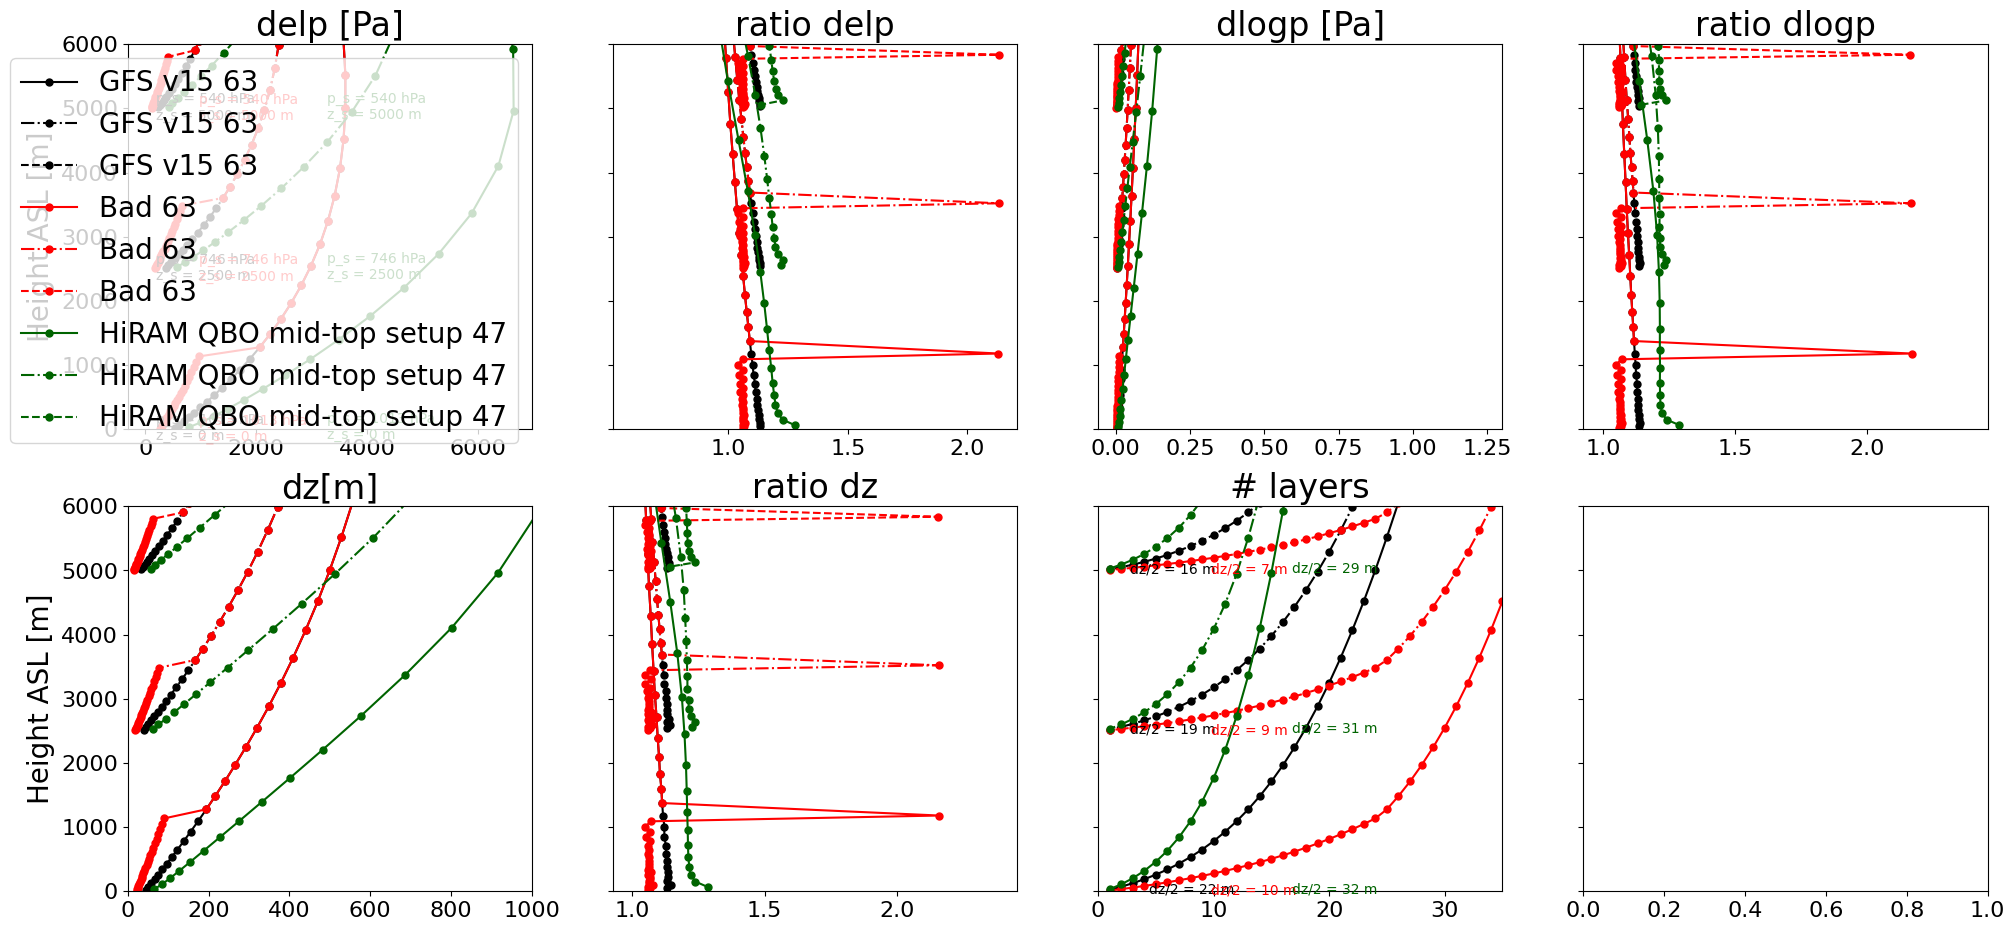

In [9]:
fv3_level_make_plots(ab_configs,zss,do_ylog,zcoord_type,zlimit_type='PBL',save=True)

If you have compiled the `fv_eta` wrapper (instructions given in `fv_eta.F90`, be sure to download `fv_eta.h` also), you can select any of the standard FV3 level setups. It is apparent different vertical level setups are chosen for different applications: in particular the kilometer-scale models (X-SHiELD and T-SHiELD) place many more levels in the boundary layer than the 13-km SHiELD, which more emphasizes consistency throughout the column.

Compilation instructions for the `fv_eta` wrapper:
- Requires an up-to-date version of `gcc` in your path, and f2py or f2py3.
- Download `fv_eta.F90` and `fv_eta.h` into the directory you are running this notebook from.

In [10]:
from fv_eta import fv_eta_mod as fv_eta

In [11]:
def write_ab_to_file(ak, bk, filename):
    assert len(ak) == len(bk), "ak and bk need to have the same length"
    ak = ak[::-1]
    bk = bk[::-1]
    with open(filename, 'w') as f:
        for k in range(len(ak)):
            f.write("{:11.4f},{:9.7f}\n".format(ak[k], bk[k]))

 stretch factor:    1.02900004    
 pint:    10000.0000    
 ptop:    40.0000000    
 s0:   0.129999995    
 k_inc:           25
 nfilter:            0
           6
 s_k_inc:    1.00000000      increase_factor:    1.40129846E-45
 var_gfs: computed model top (m)=   61.8346672      bottom/top dz=   140.505203       9304.91504    
 For (input) PINT=   100.000000      KS=          18 pint(computed)=   100.813835    
 ptop =   40.0000000    
 NO_UKMO_HB not defined
 KS=          18 PINT (mb)=   100.813835    
           1  0.849163234       9304.91406    
           2   2.00413823       5815.57031    
           3   3.63837504       4124.51953    
           4   5.66401672       3101.14062    
           5   7.99639750       2461.22266    
           6   10.5992479       2051.01953    
           7   13.4817114       1783.49609    
           8   16.7039413       1621.35938    
           9   20.3680325       1523.11914    
          10   24.6238766       1480.19336    
          11   29.61

/var/folders/mh/7cjy1s_j3w58wj1r00x7c9840000gn/T/ipykernel_75156/1451788893.py:64: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax[get_subplot_indices(plt_count, nrows, ncols)].plot(delp,zcoord_m, dash_pattern,markersize=MARKERSIZE, label=label, color=line_color, marker='o')
/var/folders/mh/7cjy1s_j3w58wj1r00x7c9840000gn/T/ipykernel_75156/1451788893.py:72: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  ax[get_subplot_indices(plt_count, nrows, ncols)].plot(delp[:-1]/delp[1:],zcoord_e[1:-1], dash_pattern,markersize=MARKERSIZE, color=line_color, marker='o')
/var/folders/mh/7cjy1s_j3w58wj1r00x7c9840000gn/T/ipykernel_75156/1451788893.py:76: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The key

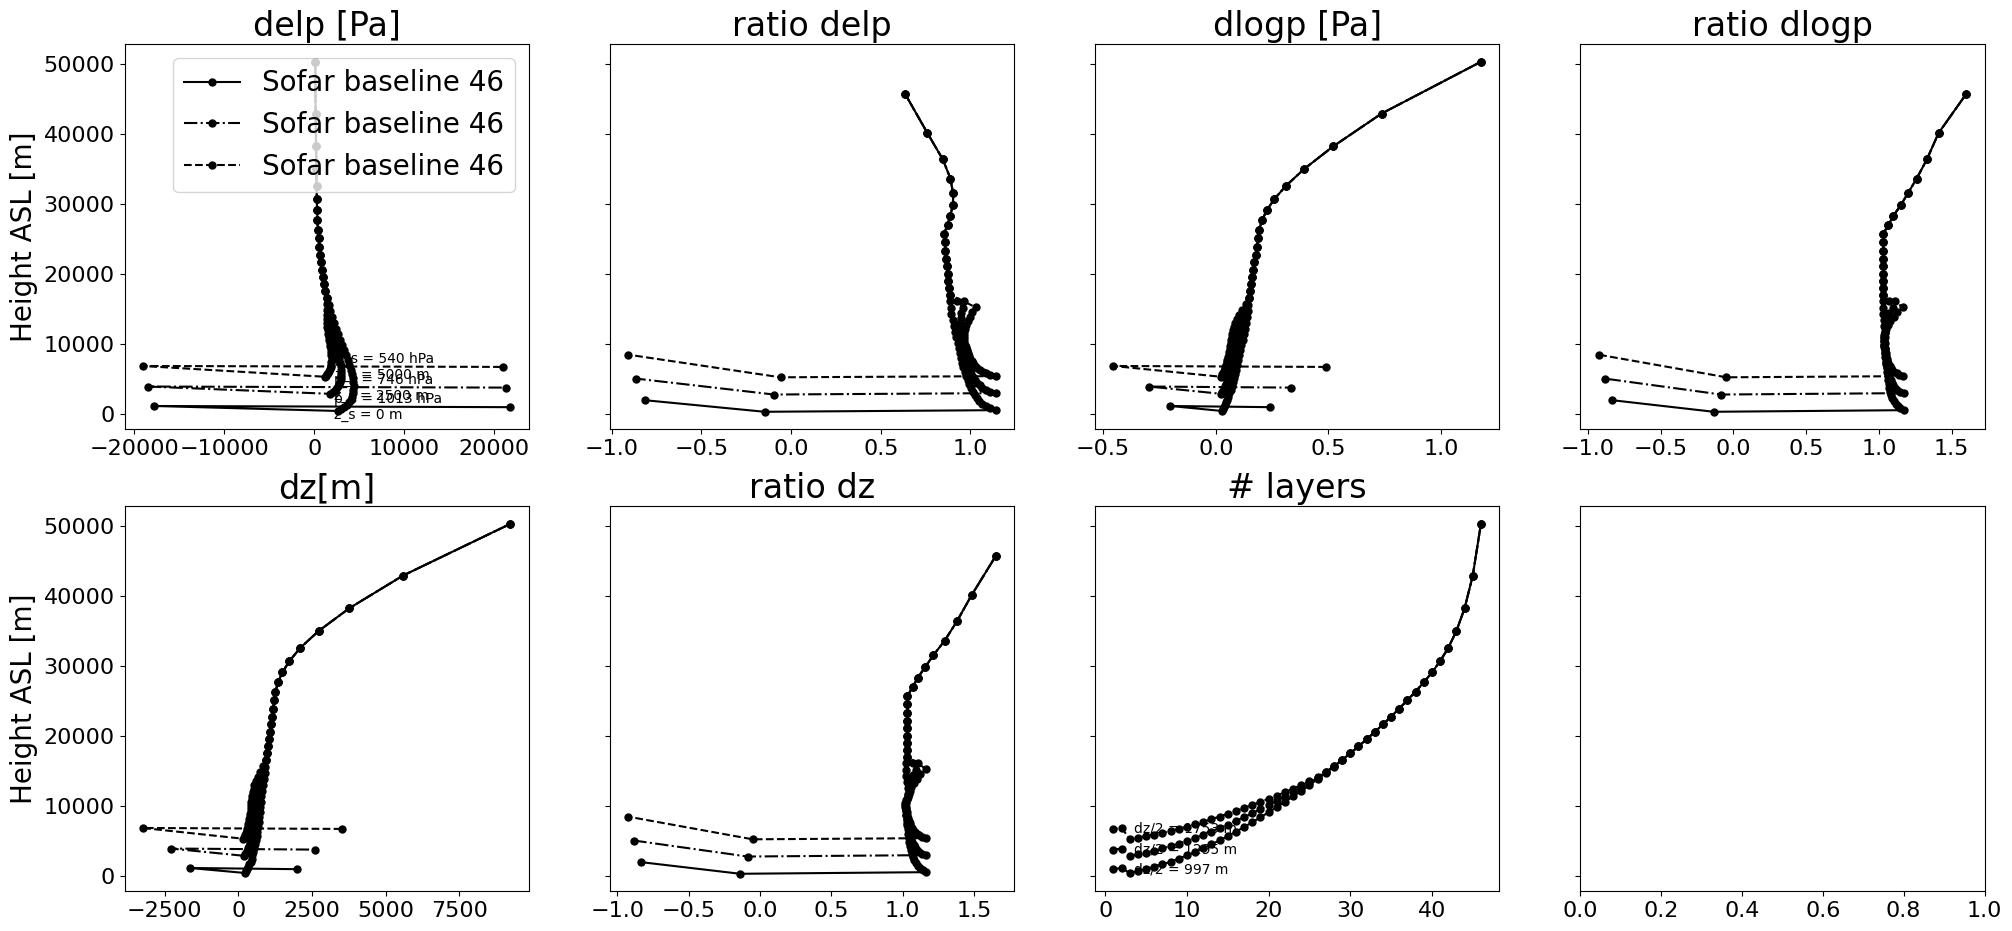

In [ ]:
ab_dict = {}
#usage: ak, bk = fv_eta.set_eta(nlev,'',stretch_fac,pint,ptop,k_inc,s0,s_k_inc)
ak, bk = fv_eta.set_eta(91,'gfs_type',False, dzmax_in=2000., stretch_fac_u_in=1.2, stretch_fac_in=1.029, pint_in= 10000., ptop_in=40, k_inc_in=25, s0_in=0.13, s_k_inc_in=1.0, nfilter_in = 0)
ab_dict = add_ab_to_dictionary(ab_dict, "Sofar baseline", ak, bk)
#write_ab_to_file(ak, bk, "sofar_91_levels")

#ak, bk = fv_eta.set_eta(46,'gfs_type',False,dzmax_in=2000., stretch_fac_u_in=1.2, stretch_fac_in=1.1,pint_in=10000,ptop_in=100,k_inc_in=15,s0_in=.2,s_k_inc_in=1.0,nfilter_in=0)
#ab_dict = add_ab_to_dictionary(ab_dict, "GFS medium-res", ak, bk)

ak, bk = fv_eta.set_eta(46,'wrf',False, dzmax_in=500., stretch_fac_u_in=5., stretch_fac_in=1.1, pint_in= 10000., ptop_in=40, k_inc_in=25, s0_in=1., s_k_inc_in=1.0, nfilter_in = 0)
write_ab_to_file(ak, bk, "sofar_46_levels")
#ab_dict = add_ab_to_dictionary(ab_dict, "WRF medium-res high top", ak, bk)

#ak, bk = fv_eta.set_eta(33,'wrf',False, dzmax_in=200., stretch_fac_u_in=4., stretch_fac_in=1.15, pint_in= 10000., ptop_in=100, k_inc_in=25, s0_in=1., s_k_inc_in=1.0, nfilter_in = 0)
#ab_dict = add_ab_to_dictionary(ab_dict, "WRF low-res", ak, bk)
ak, bk = fv_eta.set_eta(33,'wrf',False, dzmax_in=200., stretch_fac_u_in=4., stretch_fac_in=1.15, pint_in= 10000., ptop_in=40, k_inc_in=25, s0_in=1., s_k_inc_in=1.0, nfilter_in = 0)
#ab_dict = add_ab_to_dictionary(ab_dict, "WRF low-res with high top", ak, bk)
#write_ab_to_file(ak, bk, "sofar_33_levels")

fv3_level_make_plots(ab_dict,zss,do_ylog,zcoord_type, save=True)


Here are levels for two GFDL atmosphere models used for climate modeling. The 33-level AM4 setup is very similar to what GFDL has used back to AM2.1 (ca. 2003), the first FV-powered GFDL model, with the addition of a very thin first level (Shin et al., JAMES, 2018). 

In [ ]:
# f2py DOES NOT UNDERSTAND OPTIONAL ARGUMENTS AND THE CALLS BELOW WITOUT OPTIONAL ARGUMENT WILL NOT INITIALIZE THE VALUES CORRECTLY
ak, bk = fv_eta.set_eta(33,'')
fv3_level_make_plots(ak,bk,"GFDL AM4",zss,do_ylog,'p')

ak, bk = fv_eta.set_eta(63,'hitop')
fv3_level_make_plots(ak,bk,"Nonhydrostatic HiRAM",zss,do_ylog,'p')

